In [1]:
import os, torch, botorch, gpytorch
torch.set_default_dtype(torch.double)

SMOKE_TEST = os.environ.get("SMOKE_TEST")

# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f'Running on PyTorch {torch.__version__}, Botorch {botorch.__version__}, using {device} device')

c:\Users\Utente\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Running on PyTorch 1.13.0+cpu, Botorch 0.8.1, using cpu device


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = 'input_data/Case3_finer.csv'
# Data loading
def load_data(data=data):
    df = pd.read_csv(data)
    X_data  = np.vstack([df["alpha0"].to_numpy() ,
                df["alpha1"].to_numpy() ,
                df["alpha2"].to_numpy() ,
                df["alpha3"].to_numpy() ])
    pts = X_data.T.copy()
    pts = StandardScaler().fit_transform(pts)
    '''COMPUTE DIFFERENT CASES AND PLOT THEM'''
    Cx_data = df['SumCx'].to_numpy() 


    #Cx_data = np.vstack([df['SumCx'].to_numpy() ,
    #                     df['SumCy'].to_numpy() ])

    
    if Cx_data.ndim < 2:
       obs = Cx_data.reshape(-1,1).copy()
    else:
       obs = Cx_data.T.copy()

    obs = StandardScaler().fit_transform(obs)
    return pts, obs

In [22]:
from sklearn.decomposition import PCA
   
# Compute PCA 
def PCA_transformation(pts_original):
    pca = PCA(n_components=4, svd_solver='full').fit(pts_original)
    pts_transformed = pca.transform(pts_original)
    return pts_transformed

In [23]:
from pyDOE import lhs
from scipy.interpolate import NearestNDInterpolator

# Sample RSMs
def data_resample(pts, obs):
    dim = pts.shape[1]
    N = 10000
    lb = np.min( pts,axis=0)
    ub = np.max( pts,axis=0)
    bounds = {'lb': lb, 'ub': ub}
    # Generate latin-hypercube
    new_pts = lb + (ub - lb) * lhs(dim, N) 
    # pts are not in convex hull of pts (LD interpolator does not extrapolate) 
    r =  NearestNDInterpolator( pts, obs)
    # pts has to be inside region of interpolation .
    valuesTrasf = r(new_pts) 
    #valuesTrasf.reshape(-1,1).T
    return new_pts,valuesTrasf

In [24]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split

pts, obs = load_data()
pts = PCA_transformation(pts)
new_pts,new_obs = data_resample(pts, obs)

class TestcaseDataset(Dataset):
    def __init__(self,new_pts,new_obs,dim):
        data = np.hstack([new_pts,new_obs]) 
        hifi, lofi = train_test_split(data, test_size=1e-3, shuffle=True)
        hifi, test = train_test_split(hifi, test_size=1e-1)
        size=dim-data.shape[1]
        # Cast them
        self.X_hifi = torch.Tensor(hifi[:,:size]) 
        self.X_lofi = torch.Tensor(lofi[:,:size]) 
        self.X_test = torch.Tensor(test[:,:size]) 
        self.Y_hifi = torch.Tensor(hifi[:,size:])#.unsqueeze(-1)
        self.Y_lofi = torch.Tensor(lofi[:,size:])#.unsqueeze(-1)
        self.Y_test = torch.Tensor(test[:,size:])#.unsqueeze(-1)

        self.hifi_dataset = TensorDataset(self.X_hifi, self.Y_hifi)
        self.test_dataset = TensorDataset(self.X_test, self.Y_test)
    def __call__(self):
        return (self.hifi_dataset, 
                self.test_dataset, 
                self.X_hifi, 
                self.X_lofi, 
                self.X_test, 
                self.Y_hifi, 
                self.Y_lofi, 
                self.Y_test, 
                )

In [25]:
from botorch.models.transforms.outcome import Standardize
from botorch.utils.transforms import unnormalize, normalize
dataset = TestcaseDataset(new_pts,new_obs,pts.shape[1])

X_lofi = dataset.X_lofi#normalize(dataset.X_lofi,bounds=bounds)
X_hifi = dataset.X_hifi#normalize(dataset.X_hifi,bounds=bounds)
X_test = dataset.X_test#normalize(dataset.X_test,bounds=bounds)
Y_lofi = dataset.Y_lofi
Y_hifi = dataset.Y_hifi
Y_test = dataset.Y_test

hifi_dataset = dataset.hifi_dataset
test_dataset = dataset.test_dataset

print("Shape of low fidelity  X and y: ",X_lofi.shape, Y_lofi.shape)
print("Shape of high fidelity X and y: ",X_hifi.shape, Y_hifi.shape)
print("Shape of test set      X and y: ",X_test.shape, Y_test.shape)
#bounds = torch.stack([-2.5 * torch.ones(pts.shape[-1]), 2.5 * torch.ones(pts.shape[-1])])
bounds = torch.Tensor([[pts[:,0].min(), pts[:,1].min(), pts[:,2].min(), pts[:,3].min()], [pts[:,0].max(), pts[:,1].max(), pts[:,2].max(), pts[:,3].max()]])
print("Buonds shape: ", bounds.shape)

# Create data loaders
hifi_dataloader = DataLoader(hifi_dataset, batch_size = 32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=True)
best_obs_value = Y_hifi.numpy().max()

NOISE_LEVEL = 1e-1
noise = NOISE_LEVEL*torch.ones(Y_lofi.shape[0])

print('points shape',pts.shape)

Shape of low fidelity  X and y:  torch.Size([10, 4]) torch.Size([10, 1])
Shape of high fidelity X and y:  torch.Size([8991, 4]) torch.Size([8991, 1])
Shape of test set      X and y:  torch.Size([999, 4]) torch.Size([999, 1])
Buonds shape:  torch.Size([2, 4])
points shape (1292, 4)


In [26]:
# Define the Kernel of GP
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self,X_train, Y_train,likelihood):
        super(ExactGPModel, self).__init__(X_train, Y_train, likelihood)
        # this serve for prior
        #self.mean_module = gpytorch.means.ZeroMean()
        #PeriodicKernel =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        #RQKernel =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
        #self.covar_module = gpytorch.kernels.ProductKernel(PeriodicKernel,RQKernel)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

In [45]:
X_train = X_hifi[:,0]
Y_train = Y_hifi.squeeze()
Y_train.shape
X_test = X_test[:,0]
Y_test = Y_test.squeeze()

In [46]:
## FIT THE MODEL.. change X train and Y train with a subset ..

#likelihood = gpytorch.likelihoods.GaussianLikelihood()
noise_level = 0.01
noise = noise_level*torch.ones(X_train.shape[0])
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise, learn_additional_noise=True)

model = ExactGPModel(X_train, Y_train, likelihood)

In [47]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters())  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter  = 500
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train)
    loss.backward()
    if (i+1) % 100 == 0:
        print('Iter {}/{} - Loss: {} LenghtParam {} '.format(
            i + 1, training_iter, loss.item(), model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0] ))
    optimizer.step()

In [42]:
X_train.numpy().shape
Y_train.numpy().shape


(999,)

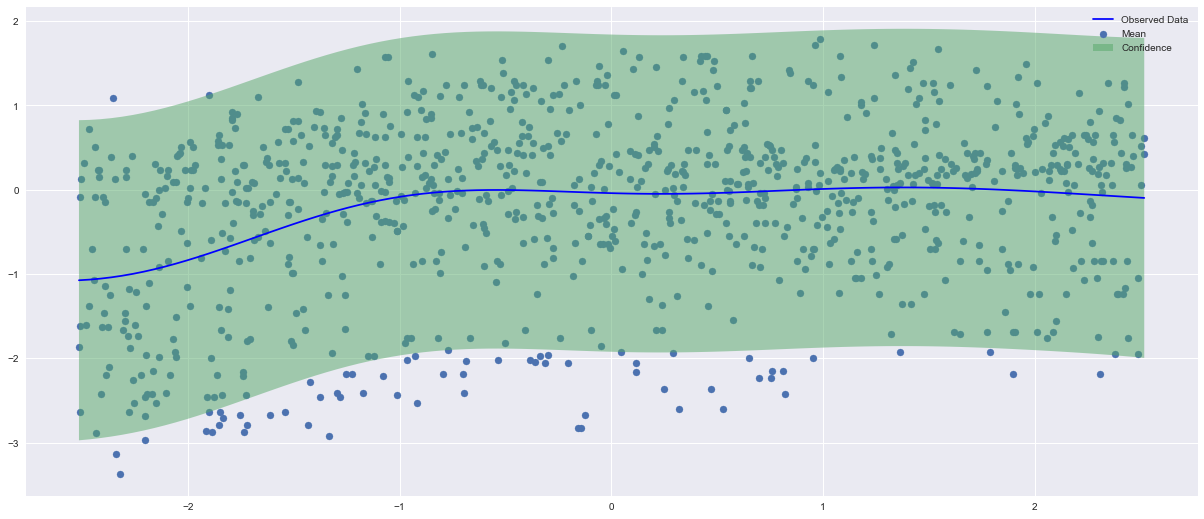

In [44]:
model.eval()
likelihood.eval()
#test_x = torch.FloatTensor(np.linspace(X_train.min(),X_train.max(),100))
test_x = torch.linspace(X_train.min(), X_train.max(), 100)
plt.style.use('seaborn')
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model(test_x)
    Y_mean = f_preds.mean
    Y_cov = f_preds.covariance_matrix
    # Make predictions by feeding model through likelihood
    observed_pred = likelihood(model(test_x))
     # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(21, 9))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    
    ax.scatter(X_train.numpy(), Y_train.numpy())
    ax.scatter(X_test.numpy(), Y_test.numpy())

    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-3, 3])
    ax.legend(['Observed Data','Test','Mean','Confidence'])
